In [1]:
!nvidia-smi

Wed Jul 12 11:38:54 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.47                 Driver Version: 531.68       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3080 L...    On | 00000000:01:00.0 Off |                  N/A |
| N/A   57C    P8               10W /  N/A|     13MiB /  8192MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [7]:
# Same as just LSTM.
# Refer to ./stock_price_expectation_LSTM.ipynb

import pandas as pd
import numpy as np

def MinMaxScaler(data):

    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)

    return numerator / (denominator + 1e-7)             # To prevent DivideByZero exception

df = pd.read_csv("https://raw.githubusercontent.com/KnightChaser/ML-challenge/main/EX_challenging_problems/06_stock_price_expectation/samsung_electronics.csv")
dfx = df[["Volume", "Open", "High", "Low", "Close"]]

dfx = MinMaxScaler(dfx)
dfy = dfx[["Close"]]                            # We are going to expect the close price
dfx = dfx[["Volume", "Open", "High", "Low"]]    # Only given data

X = dfx.values.tolist()     # input
y = dfy.values.tolist()     # (expected) output

############################################### (OHLVC)
window_size = 7         # period

data_X = []
data_y = []

for _seq in range(len(y) - window_size):
    _X = X[_seq : _seq + window_size]
    _y = y[_seq + window_size]
    data_X.append(_X)
    data_y.append(_y)
###############################################

############################################### (PREPROCESSING)
from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y = train_test_split(data_X, data_y, train_size = 0.2, random_state = 0xCAFE)

train_size = int(len(data_y) * 0.7)             # Train dataset will take 70% of proportion
train_X = np.array(data_X[0 : train_size])
train_y = np.array(data_y[0 : train_size])

test_size = len(data_y) - train_size
test_X = np.array(data_X[train_size : len(data_X)])
test_y = np.array(data_y[train_size : len(data_y)])
###############################################

In [8]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional

model = Sequential()
model.add(Bidirectional(LSTM(units = 64, activation='tanh', return_sequences = True, input_shape = (window_size, 4))))
model.add(Dropout(0.1))
model.add(Bidirectional(LSTM(units = 32, activation='tanh')))
model.add(Dropout(0.1))
model.add(Dense(units = 1))                     # The output is only a single value.

from tensorflow._api.v2.config import optimizer
from tensorflow import keras

model.compile(loss = "mean_squared_error",         # <-- REGRESSION
              metrics = "mae",
              optimizer = "adam")

early_stopping_checkpoint = keras.callbacks.EarlyStopping(patience = 16, restore_best_weights = True, mode = "auto")

history = model.fit(train_X, train_y,
                    epochs = 500,
                    steps_per_epoch = 50,
                    batch_size = 8,
                    validation_data = (test_X, test_y),
                    callbacks = [early_stopping_checkpoint])

Epoch 1/500
50/50 [==============================] - 6s 31ms/step - loss: 0.0285 - mae: 0.1133 - val_loss: 0.0022 - val_mae: 0.0382
Epoch 2/500
50/50 [==============================] - 1s 15ms/step - loss: 0.0048 - mae: 0.0546 - val_loss: 0.0026 - val_mae: 0.0409
Epoch 3/500
50/50 [==============================] - 1s 14ms/step - loss: 0.0042 - mae: 0.0499 - val_loss: 0.0023 - val_mae: 0.0403
Epoch 4/500
50/50 [==============================] - 1s 14ms/step - loss: 0.0044 - mae: 0.0523 - val_loss: 0.0028 - val_mae: 0.0417
Epoch 5/500
50/50 [==============================] - 1s 18ms/step - loss: 0.0035 - mae: 0.0468 - val_loss: 0.0031 - val_mae: 0.0435
Epoch 6/500
50/50 [==============================] - 1s 18ms/step - loss: 0.0045 - mae: 0.0522 - val_loss: 0.0022 - val_mae: 0.0383
Epoch 7/500
50/50 [==============================] - 1s 22ms/step - loss: 0.0036 - mae: 0.0466 - val_loss: 0.0030 - val_mae: 0.0424
Epoch 8/500
50/50 [==============================] - 1s 18ms/step - loss: 0.

5/5 [==============================] - 1s 10ms/step


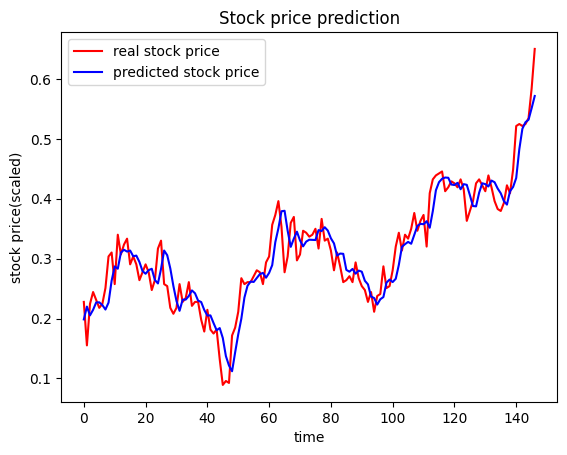

In [11]:
import matplotlib.pyplot as plt

pred_y = model.predict(test_X)

plt.figure()
plt.plot(test_y, color='red', label='real stock price')
plt.plot(pred_y, color='blue', label='predicted stock price')
plt.title('Stock price prediction')
plt.xlabel('time')
plt.ylabel('stock price(scaled)')
plt.legend()
plt.show()

In [13]:
fiat_currency = "KRW"

print(f"Tomorrow's expected stock price: {(df['Close'].iloc[-1] * pred_y[-1]) / dfy['Close'].iloc[-1]} {fiat_currency}")

Tomorrow's expected stock price: [63558.71336209] KRW
